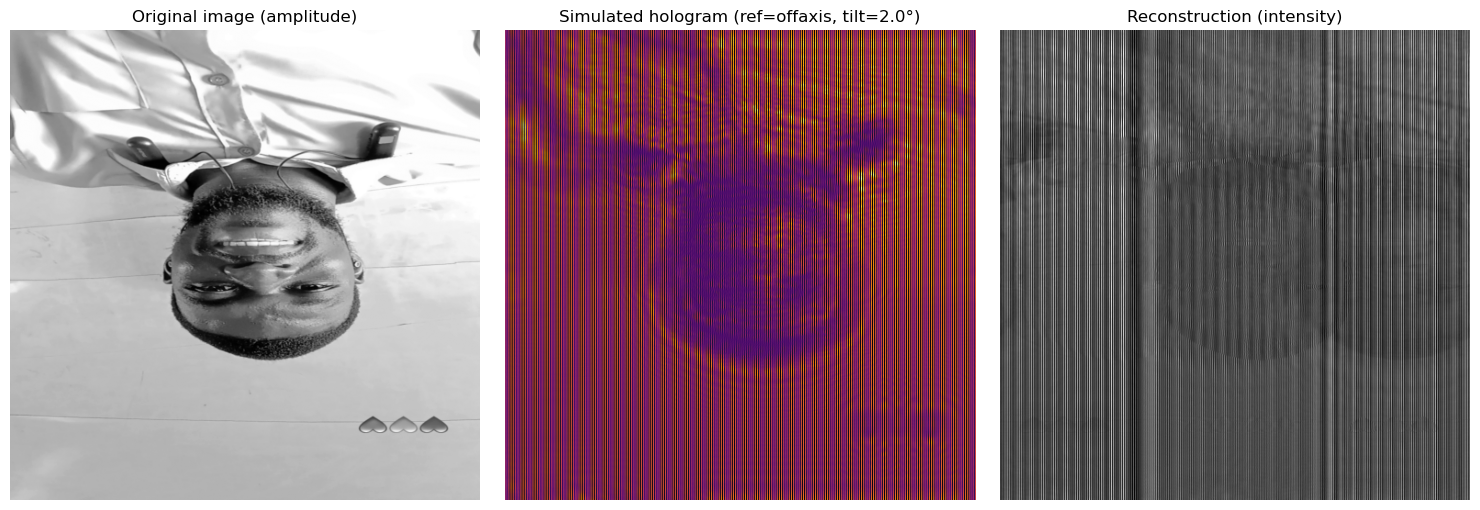

Saved outputs to: holo_outputs


In [1]:
# Digital holography camera simulator for a real image (Jupyter-ready)
# - Load a local image (jpg/png)
# - Treat brightness as amplitude transmission
# - Propagate via Fresnel transfer function to simulate camera hologram
# - Interfere with a reference (on-axis or off-axis)
# - Reconstruct via back-propagation
# - Display and optionally save results

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

#parameters 
image_path = r"C:\Users\HP\Desktop\New folder (3)\Snapchat-780523967.jpg" #Dear reader, kindly set this to your local image path
N = 512                    # grid size (NxN). 256 or 512 recommended
physical_size = 5e-3       # meters (extent of object/sensor plane). Adjust for scale realism
wavelength = 633e-9        # meters (red HeNe)
z = 0.05                   # propagation distance (m) between object and sensor
ref_type = "offaxis"       # "onaxis" or "offaxis"
ref_tilt_deg = 2.0         # degrees (if offaxis)
pad_factor = 1             # 1=no padding; 2 recommended to reduce wrap artifacts
add_phase = False          # If True, add synthetic phase to object (useful for phase objects)
phase_strength = 2.0       # radians amplitude if add_phase True
save_outputs = True
output_dir = "holo_outputs"  # where to save results

#Derived params & helpers 
k = 2 * np.pi / wavelength
dx = physical_size / N     # pixel pitch
fx = np.fft.fftfreq(N, d=dx)
FX, FY = np.meshgrid(np.fft.fftshift(fx), np.fft.fftshift(fx))

def fresnel_transfer(N, dx, wavelength, z):
    #Build Fresnel transfer function H for size N, sampling dx, distance z.
    fx = np.fft.fftfreq(N, d=dx)
    FY, FX = np.meshgrid(np.fft.fftshift(fx), np.fft.fftshift(fx))
    H = np.exp(1j * k * z) * np.exp(-1j * np.pi * wavelength * z * (FX**2 + FY**2))
    return np.fft.ifftshift(H)

def fresnel_propagate(u0, H):
    #Propagate field u0 (NxN complex) using transfer H (ifftshifted).
    U0 = np.fft.fft2(u0)
    U1 = U0 * H
    u1 = np.fft.ifft2(U1)
    return u1

def make_reference(N, dx, wavelength, ref_type="offaxis", tilt_deg=2.0):
    x = np.linspace(-physical_size/2, physical_size/2, N)
    X, Y = np.meshgrid(x, x)
    if ref_type == "onaxis":
        return np.ones((N, N), dtype=complex)
    theta = np.deg2rad(tilt_deg)
    kx = k * np.sin(theta)
    ky = 0.0
    return np.exp(1j * (kx * X + ky * Y))

# ------------------ Load & preprocess image ------------------
if not os.path.exists(image_path):
    raise FileNotFoundError(f"Image not found. Set image_path to a valid file on your PC: {image_path}")

img = Image.open(image_path).convert("L")   # grayscale
img = img.resize((N, N), Image.BILINEAR)
A = np.asarray(img, dtype=float) / 255.0    # amplitude in [0,1]

# optionally add a phase map (for phase objects)
if add_phase:
    rng = np.random.default_rng(0)
    phi = phase_strength * (rng.standard_normal((N, N)))
else:
    phi = np.zeros((N, N))

U_obj = A * np.exp(1j * phi)  # complex object field in object plane

# ------------------ Physics: propagate object to sensor, interfere with ref, record hologram ------------------
H = fresnel_transfer(N, dx, wavelength, z)
U_obj_sensor = fresnel_propagate(U_obj, H)

U_ref_sensor = make_reference(N, dx, wavelength, ref_type=ref_type, tilt_deg=ref_tilt_deg)

# Simulated camera hologram: intensity of (object wave + reference)
U_total = U_obj_sensor + U_ref_sensor
I_hologram = np.abs(U_total)**2
I_hologram /= I_hologram.max()  # normalize to [0,1] for display/save

# Optionally add simple noise (uncomment to test)
# I_hologram = I_hologram + 0.01 * np.random.randn(N, N)  # small gaussian read noise
# I_hologram = np.clip(I_hologram, 0, 1)

# ------------------ Reconstruction: back-propagate (naive) ------------------
# Approach: assume recorded amplitude sqrt(I) with reference phase, backpropagate
recorded_field = np.sqrt(np.clip(I_hologram, 0, None)) * np.exp(1j * np.angle(U_ref_sensor))
U_rec = fresnel_propagate(recorded_field, np.conj(H))  # backprop using conjugate of H (equivalently -z)
recon_int = np.abs(U_rec)**2
recon_int /= recon_int.max()

# ------------------ Display results ------------------
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(A, cmap='gray', origin='lower')
axes[0].set_title("Original image (amplitude)")
axes[0].axis('off')

axes[1].imshow(I_hologram, cmap='inferno', origin='lower')
axes[1].set_title(f"Simulated hologram (ref={ref_type}, tilt={ref_tilt_deg}°)")
axes[1].axis('off')

axes[2].imshow(recon_int, cmap='gray', origin='lower')
axes[2].set_title("Reconstruction (intensity)")
axes[2].axis('off')

plt.tight_layout()
plt.show()

# ------------------ Save outputs ------------------
if save_outputs:
    os.makedirs(output_dir, exist_ok=True)
    Image.fromarray((A * 255).astype(np.uint8)).save(os.path.join(output_dir, "object_amplitude.png"))
    Image.fromarray(np.uint8(plt.cm.inferno(I_hologram)[:, :, :3] * 255)).save(os.path.join(output_dir, "simulated_hologram.png"))
    Image.fromarray((recon_int * 255).astype(np.uint8)).save(os.path.join(output_dir, "reconstruction.png"))
    print("Saved outputs to:", output_dir)
